In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import cv2 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Flatten, Rescaling
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras import backend as K

In [2]:
# Loading MNIST data having images of handwritten digits [1,2,3,6,9]

root_dir = "..\CS671_Assignment3\Group_13"
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"val")
test_dir = os.path.join(root_dir,"test")

In [3]:
class_map = {1:0,2:1,3:2,6:3,9:4}
def load_data(path):
    x,y = [],[]
    class_dirs = ["1","2","3","6","9"]

    for class_dir in class_dirs:
        class_path = os.path.join(path,class_dir)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path,img_file)
            
            #reading image
            img = cv2.imread(img_path,-1)
            x.append(np.array(img))
            y.append(class_map[int(class_dir)])
    x=np.array(x)
    #y=np.array(list(map(int, y)))
    y=to_categorical(y,num_classes=5)
    return x,y

In [4]:
train_x,train_y=load_data(train_dir)
val_x,val_y=load_data(val_dir)
test_x,test_y=load_data(test_dir)

In [6]:
# normalizing data
from sklearn.preprocessing import MinMaxScaler

train_x_flat=train_x.reshape(train_x.shape[0],-1)
val_x_flat=val_x.reshape(val_x.shape[0],-1)
test_x_flat=test_x.reshape(test_x.shape[0],-1)

scaler=MinMaxScaler()
scaler.fit(train_x_flat)
train_x_scaled=scaler.transform(train_x_flat)
val_x_scaled=scaler.transform(val_x_flat)
test_x_scaled=scaler.transform(test_x_flat)

In [7]:
# adding noise to data with probability 'p'
def add_noise(data,p=0.2,mu=0,std=1):
    
    #generate a matrix with {0,1} where 1 appears with probability 'p' to add noise
    # and 0 appears with probability '1-p' to retain corresponding feature
    t=np.random.binomial(1,p,size=data.shape)
    
    # add gaussian noise to data
    noisy_data=data+np.random.normal(loc=mu,scale=std,size=data.shape)*t
    
    #scaling of noisy data
    scaler=MinMaxScaler()
    scaler.fit(noisy_data)
    noisy_data_scaled=scaler.transform(train_x_flat)
    return noisy_data_scaled

In [34]:
# set weight initializer for Keras layers
weights_ini=initializers.RandomNormal(mean=0,stddev=0.5,seed=123)
bias_ini=initializers.Zeros()

In [35]:
# single hidden layer autoencoder
inputs = Input(shape=(784,),name='input_layer')
l1=Dense(64, kernel_initializer=weights_ini, bias_initializer=bias_ini, activation = 'sigmoid',name='middle_layer')(inputs)
outputs = Dense(784, kernel_initializer=weights_ini, bias_initializer=bias_ini, activation = 'sigmoid', name='output_layer')(l1)

full_model = Model(inputs=inputs, outputs=outputs)
encoder = Model(inputs=inputs, outputs=l1)
decoder = Model(inputs=l1, outputs=outputs)

In [36]:
full_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 middle_layer (Dense)        (None, 64)                50240     
                                                                 
 output_layer (Dense)        (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Setting optimiser
opt_Adam = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,name="Adam")

# compiling model
full_model.compile(optimizer=opt_Adam,loss="mse",metrics=["mean_squared_error"])

# setting convergence criterion
my_callbacks = EarlyStopping(monitor='loss',min_delta=0.0001,patience=10,verbose=1)

In [38]:
# fitting model with noisy data
num_epochs=200
loss=[]
for epoch in range(num_epochs):
    print('epoch: ',epoch+1)
    train_x_noisy=add_noise(train_x_scaled,p=0.2)
    model_train=full_model.fit(train_x_noisy,train_x_scaled,batch_size=32,epochs=1,callbacks=my_callbacks,verbose=1,
                               validation_data=(val_x_scaled,val_x_scaled),shuffle=True)
    loss.append(model_train.history['loss'])

epoch:  1
356/356 [==============================] - 5s 12ms/step - loss: 0.1158 - mean_squared_error: 0.1158 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
epoch:  2
356/356 [==============================] - 4s 11ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0542 - val_mean_squared_error: 0.0542
epoch:  3
356/356 [==============================] - 4s 11ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0485 - val_mean_squared_error: 0.0485
epoch:  4
356/356 [==============================] - 4s 11ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
epoch:  5
356/356 [==============================] - 4s 11ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
epoch:  6
356/356 [==============================] - 4s 11ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
epoch:  7
356/356 [=========

356/356 [==============================] - 4s 12ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
epoch:  102
356/356 [==============================] - 4s 12ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
epoch:  103
356/356 [==============================] - 4s 12ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
epoch:  104
356/356 [==============================] - 43s 121ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
epoch:  105
356/356 [==============================] - 6s 18ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
epoch:  106
356/356 [==============================] - 6s 15ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
epoch:  107
356/356 [=====

356/356 [==============================] - 5s 14ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
epoch:  152
356/356 [==============================] - 5s 14ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
epoch:  153
356/356 [==============================] - 5s 13ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
epoch:  154
356/356 [==============================] - 5s 13ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
epoch:  155
356/356 [==============================] - 5s 13ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
epoch:  156
356/356 [==============================] - 5s 13ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
epoch:  157
356/356 [=======

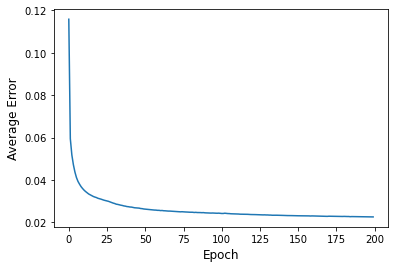

In [39]:
plt.plot(loss)
plt.ylabel('Average Error',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.savefig('./img/loss_noise1.png')
plt.show()

In [40]:
# Average reconstruction error

train_loss=full_model.evaluate(train_x_flat,train_x_scaled)[0]
val_loss=full_model.evaluate(val_x_flat,val_x_scaled)[0]
test_loss=full_model.evaluate(test_x_flat,test_x_scaled)[0]

119/119 [==============================] - 1s 6ms/step - loss: 0.0367 - mean_squared_error: 0.0367


In [41]:
train_out = full_model.predict(train_x_scaled)
val_out = full_model.predict(val_x_scaled)
test_out = full_model.predict(test_x_scaled)

119/119 [==============================] - 1s 6ms/step


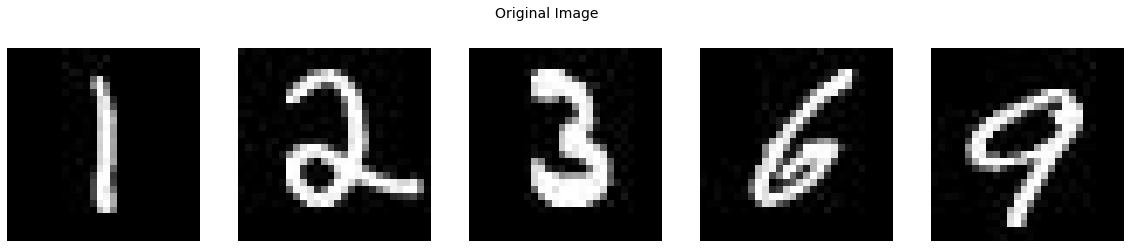

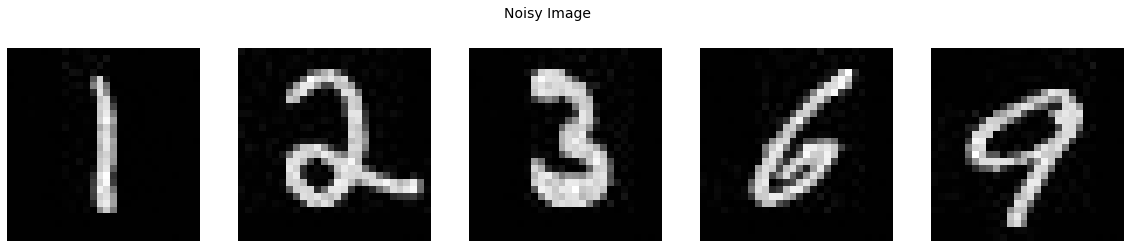

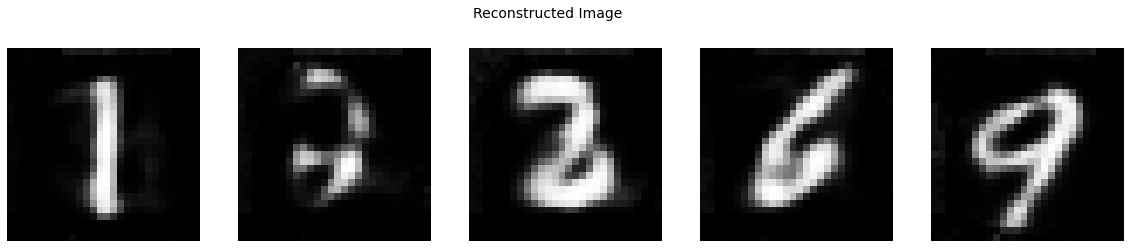

In [42]:
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=2277*i
    ax.imshow(train_x[j],cmap='gray')     # original image
    ax.axis('off')
fig.suptitle('Original Image',fontsize=14)
plt.savefig('./img/org_noise1.png')
plt.show()
plt.close()

fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=2277*i
    noisy=cv2.normalize(train_x_noisy[j].reshape(28,28),None,255,0,cv2.NORM_MINMAX,cv2.CV_8U)
    ax.imshow(noisy,cmap='gray')    
    ax.axis('off')
fig.suptitle('Noisy Image',fontsize=14)
plt.savefig('./img/noise_noise1.png')
plt.show()
plt.close()

fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=2277*i
    recon = cv2.normalize(train_out[j].reshape(28,28),None,255,0,cv2.NORM_MINMAX,cv2.CV_8U)   # reconstructed image
    ax.imshow(recon,cmap='gray')    
    ax.axis('off')
fig.suptitle('Reconstructed Image',fontsize=14)
plt.savefig('./img/recon_noise1.png')
plt.show()
plt.close()

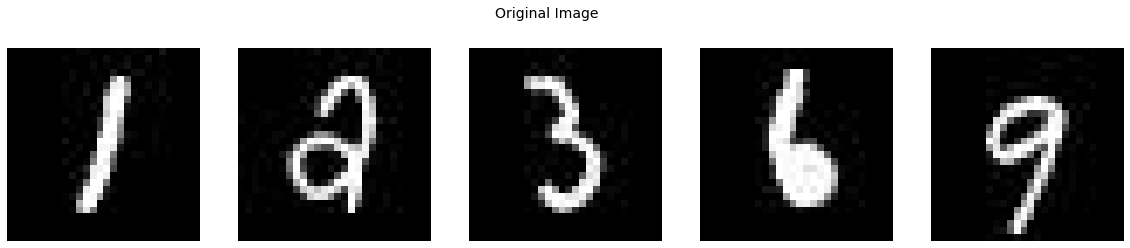

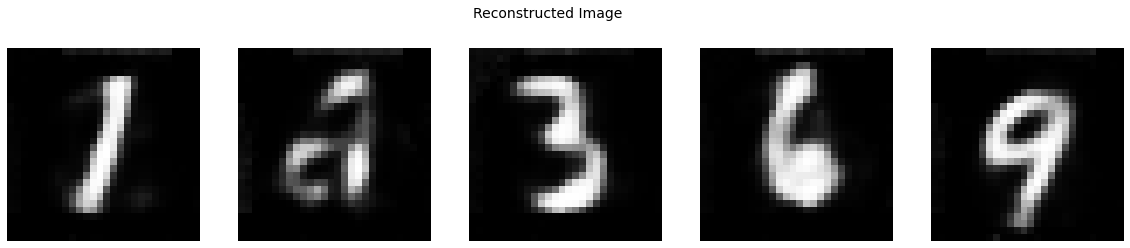

In [43]:
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=759*i
    ax.imshow(val_x[j],cmap='gray')     # original image
    ax.axis('off')
fig.suptitle('Original Image',fontsize=14)
plt.savefig('./img/org_val_noise1.png')
plt.show()
plt.close()
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=759*i
    recon = cv2.normalize(val_out[j].reshape(28,28),None,255,0,cv2.NORM_MINMAX,cv2.CV_8U)   # reconstructed image
    ax.imshow(recon,cmap='gray')    
    ax.axis('off')
fig.suptitle('Reconstructed Image',fontsize=14)
plt.savefig('./img/recon_val_noise1.png')
plt.show()
plt.close()

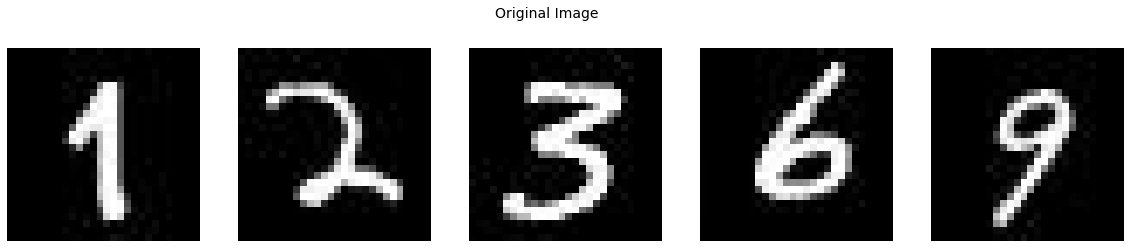

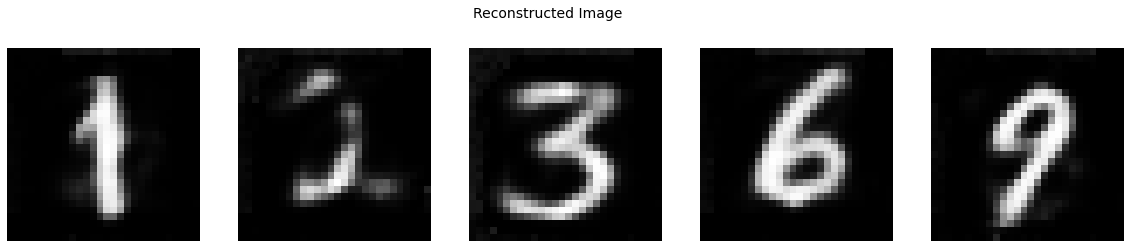

In [44]:
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=759*i
    ax.imshow(test_x[j],cmap='gray')     # original image
    ax.axis('off')
fig.suptitle('Original Image',fontsize=14)
plt.savefig('./img/org_test_noise1.png')
plt.show()
plt.close()
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    j=759*i
    recon = cv2.normalize(test_out[j].reshape(28,28),None,255,0,cv2.NORM_MINMAX,cv2.CV_8U)   # reconstructed image
    ax.imshow(recon,cmap='gray')    
    ax.axis('off')
fig.suptitle('Reconstructed Image',fontsize=14)
plt.savefig('./img/256/recon_test_noise1.png')
plt.show()
plt.close()

## Training a FCNN using compressed represenatation

In [45]:
# Getting compressed representation of train, validation and test data to further use to train FCNN

encoded_train = encoder.predict([train_x_scaled])
encoded_val = encoder.predict([val_x_scaled])
encoded_test = encoder.predict([test_x_scaled])

119/119 [==============================] - 1s 5ms/step


In [46]:
# 3 layer FCNN with sigmoidal activation at hidden layers and softmax at output layer

model1 = keras.Sequential([
        Input(shape=(64,),name='input_layer'),
        Dense(512,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_1"),
        Dense(256,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_2"),
        Dense(128,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_3"),
        Dense(5,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="softmax",name="output_layer")
        ])

In [47]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               33280     
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 198,149
Trainable params: 198,149
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Setting optimiser
opt_Adam = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,name="Adam")

# compiling model
model1.compile(optimizer=opt_Adam,loss="categorical_crossentropy",metrics=["accuracy"])

# setting convergence criterion
my_callbacks = EarlyStopping(monitor='loss',min_delta=0.00001,patience=10,verbose=1)

In [49]:
# fitting model
FCNN1_train=model1.fit(encoded_train,train_y,batch_size=32,epochs=10000,callbacks=my_callbacks,verbose="auto",
                       validation_data=(encoded_val,val_y),shuffle=True)

Epoch 1/10000
356/356 [==============================] - 10s 26ms/step - loss: 0.3683 - accuracy: 0.8902 - val_loss: 0.1962 - val_accuracy: 0.9375
Epoch 2/10000
356/356 [==============================] - 9s 26ms/step - loss: 0.1392 - accuracy: 0.9575 - val_loss: 0.1329 - val_accuracy: 0.9563
Epoch 3/10000
356/356 [==============================] - 9s 26ms/step - loss: 0.1104 - accuracy: 0.9652 - val_loss: 0.1270 - val_accuracy: 0.9594
Epoch 4/10000
356/356 [==============================] - 9s 26ms/step - loss: 0.0952 - accuracy: 0.9701 - val_loss: 0.1100 - val_accuracy: 0.9671
Epoch 5/10000
356/356 [==============================] - 9s 26ms/step - loss: 0.0879 - accuracy: 0.9727 - val_loss: 0.1016 - val_accuracy: 0.9689
Epoch 6/10000
356/356 [==============================] - 9s 26ms/step - loss: 0.0806 - accuracy: 0.9742 - val_loss: 0.1042 - val_accuracy: 0.9692
Epoch 7/10000
356/356 [==============================] - 9s 25ms/step - loss: 0.0722 - accuracy: 0.9763 - val_loss: 0.1025 

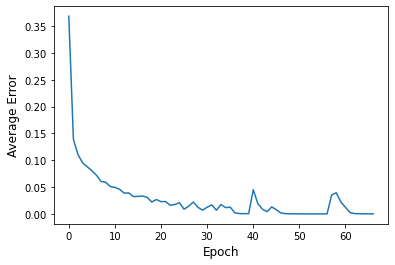

In [51]:
# Average error plot on train data
history = FCNN1_train.history

import pickle
with open('./models/history_FCNN1_noise1.pkl','wb') as f:
    pickle.dump(history,f)

plt.plot(history['loss'])
plt.ylabel('Average Error',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.savefig('./models/loss1_noise1.png')
plt.show()

In [52]:
# saving model
model1.save("./models/FCNN1_noise1.h5")

In [53]:
# Accuracy and loss on validation data
val_loss,val_acc=model1.evaluate(encoded_val,val_y)

print('Validation loss: {} \t Validation accuracy: {}'.format(val_loss,val_acc))

119/119 [==============================] - 1s 8ms/step - loss: 0.1128 - accuracy: 0.9763
Validation loss: 0.11282646656036377 	 Validation accuracy: 0.9762845635414124


In [54]:
# 4 layer FCNN with sigmoidal activation at hidden layers and softmax at output layer

model2 = keras.Sequential([
        Input(shape=(64,),name='input_layer'),
        Dense(512,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_1"),
        Dense(256,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_2"),
        Dense(128,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_3"),
        Dense(64,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_4"),
        Dense(5,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="softmax",name="output_layer")
        ])

In [55]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               33280     
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 5)                 325       
                                                                 
Total params: 206,085
Trainable params: 206,085
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Setting optimiser
opt_Adam = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,name="Adam")

# compiling model
model2.compile(optimizer=opt_Adam,loss="categorical_crossentropy",metrics=["accuracy"])

# setting convergence criterion
my_callbacks = EarlyStopping(monitor='loss',min_delta=0.0001,patience=10,verbose=1)

In [57]:
# fitting model
FCNN2_train=model2.fit(encoded_train,train_y,batch_size=32,epochs=10000,callbacks=my_callbacks,verbose="auto",
         validation_data=(encoded_val,val_y),shuffle=True)

Epoch 1/10000
356/356 [==============================] - 6s 15ms/step - loss: 0.3701 - accuracy: 0.8938 - val_loss: 0.1497 - val_accuracy: 0.9563
Epoch 2/10000
356/356 [==============================] - 6s 17ms/step - loss: 0.1443 - accuracy: 0.9570 - val_loss: 0.1350 - val_accuracy: 0.9605
Epoch 3/10000
356/356 [==============================] - 6s 17ms/step - loss: 0.1206 - accuracy: 0.9612 - val_loss: 0.1576 - val_accuracy: 0.9528
Epoch 4/10000
356/356 [==============================] - 6s 16ms/step - loss: 0.0975 - accuracy: 0.9710 - val_loss: 0.1029 - val_accuracy: 0.9679
Epoch 5/10000
356/356 [==============================] - 6s 18ms/step - loss: 0.0885 - accuracy: 0.9723 - val_loss: 0.1083 - val_accuracy: 0.9671
Epoch 6/10000
356/356 [==============================] - 4s 12ms/step - loss: 0.0801 - accuracy: 0.9745 - val_loss: 0.0947 - val_accuracy: 0.9684
Epoch 7/10000
356/356 [==============================] - 6s 16ms/step - loss: 0.0763 - accuracy: 0.9762 - val_loss: 0.1030 -

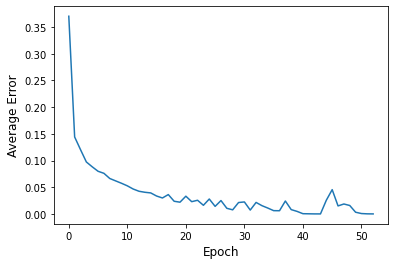

In [58]:
# Average error plot on train data
history = FCNN2_train.history
import pickle
with open('./models/history_FCNN2_noise1.pkl','wb') as f:
    pickle.dump(history,f)

plt.plot(history['loss'])
plt.ylabel('Average Error',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.savefig('./models/loss2_noise1.png')
plt.show()

In [59]:
# saving model
model2.save("./models/FCNN2_noise1.h5")

In [60]:
# Accuracy and loss on validation data
val_loss,val_acc=model2.evaluate(encoded_val,val_y)
print('Validation loss: {} \t Validation accuracy: {}'.format(val_loss,val_acc))

119/119 [==============================] - 1s 7ms/step - loss: 0.1202 - accuracy: 0.9755
Validation loss: 0.12020790576934814 	 Validation accuracy: 0.9754940867424011


In [61]:
# 5 layer FCNN with sigmoidal activation at hidden layers and softmax at output layer

model3 = keras.Sequential([
        Input(shape=(64,),name='input_layer'),
        Dense(512,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_1"),
        Dense(256,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_2"),
        Dense(128,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_3"),
        Dense(64,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_4"),
        Dense(32,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="sigmoid",name="hidden_layer_5"),
        Dense(5,kernel_initializer=weights_ini,bias_initializer=bias_ini,activation="softmax",name="output_layer")
        ])

In [62]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               33280     
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_5 (Dense)      (None, 32)                2080      
                                                                 
 output_layer (Dense)        (None, 5)                 165       
                                                                 
Total params: 208,005
Trainable params: 208,005
Non-tr

In [63]:
# Setting optimiser
opt_Adam = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,name="Adam")

# compiling model
model3.compile(optimizer=opt_Adam,loss="categorical_crossentropy",metrics=["accuracy"])

# setting convergence criterion
my_callbacks = EarlyStopping(monitor='loss',min_delta=0.0001,patience=10,verbose=1)

In [64]:
# fitting model
FCNN3_train=model3.fit(encoded_train,train_y,batch_size=32,epochs=10000,callbacks=my_callbacks,verbose="auto",
                       validation_data=(encoded_val,val_y),shuffle=True)

Epoch 1/10000
356/356 [==============================] - 7s 18ms/step - loss: 0.4477 - accuracy: 0.8836 - val_loss: 0.2221 - val_accuracy: 0.9347
Epoch 2/10000
356/356 [==============================] - 7s 19ms/step - loss: 0.1552 - accuracy: 0.9564 - val_loss: 0.1388 - val_accuracy: 0.9589
Epoch 3/10000
356/356 [==============================] - 7s 19ms/step - loss: 0.1224 - accuracy: 0.9635 - val_loss: 0.1406 - val_accuracy: 0.9602
Epoch 4/10000
356/356 [==============================] - 7s 20ms/step - loss: 0.1096 - accuracy: 0.9663 - val_loss: 0.1234 - val_accuracy: 0.9631
Epoch 5/10000
356/356 [==============================] - 7s 19ms/step - loss: 0.0966 - accuracy: 0.9705 - val_loss: 0.1289 - val_accuracy: 0.9599
Epoch 6/10000
356/356 [==============================] - 7s 18ms/step - loss: 0.0841 - accuracy: 0.9734 - val_loss: 0.1002 - val_accuracy: 0.9681
Epoch 7/10000
356/356 [==============================] - 7s 19ms/step - loss: 0.0802 - accuracy: 0.9744 - val_loss: 0.1063 -

Epoch 57/10000
356/356 [==============================] - 6s 17ms/step - loss: 2.6159e-04 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9760
Epoch 58/10000
356/356 [==============================] - 6s 17ms/step - loss: 2.2545e-04 - accuracy: 1.0000 - val_loss: 0.1218 - val_accuracy: 0.9760
Epoch 59/10000
356/356 [==============================] - 6s 17ms/step - loss: 1.9331e-04 - accuracy: 1.0000 - val_loss: 0.1232 - val_accuracy: 0.9760
Epoch 60/10000
356/356 [==============================] - 6s 17ms/step - loss: 1.6830e-04 - accuracy: 1.0000 - val_loss: 0.1242 - val_accuracy: 0.9760
Epoch 61/10000
356/356 [==============================] - 6s 17ms/step - loss: 1.4541e-04 - accuracy: 1.0000 - val_loss: 0.1262 - val_accuracy: 0.9760
Epoch 62/10000
356/356 [==============================] - 6s 16ms/step - loss: 1.2714e-04 - accuracy: 1.0000 - val_loss: 0.1279 - val_accuracy: 0.9768
Epoch 63/10000
356/356 [==============================] - 5s 15ms/step - loss: 1.1165e-04 - ac

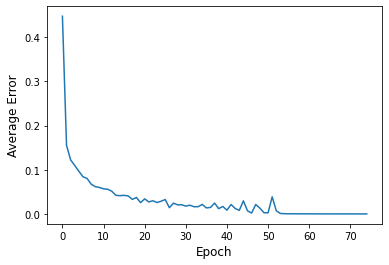

In [65]:
# Average error plot on train data
history = FCNN3_train.history
import pickle
with open('./models/history_FCNN3_noise1.pkl','wb') as f:
    pickle.dump(history,f)

plt.plot(history['loss'])
plt.ylabel('Average Error',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.savefig('./models/loss3_noise1.png')
plt.show()

In [66]:
# saving model
model3.save("./models/FCNN3_noise1.h5")

In [67]:
# Accuracy and loss on validation data
val_loss,val_acc=model3.evaluate(encoded_val,val_y)
print('Validation loss: {} \t Validation accuracy: {}'.format(val_loss,val_acc))

119/119 [==============================] - 1s 9ms/step - loss: 0.1539 - accuracy: 0.9763
Validation loss: 0.1538761705160141 	 Validation accuracy: 0.9762845635414124


## Model accuracy and confusion matrix for best selected architecture

In [68]:
from keras import models

best=models.load_model("./models/FCNN1_noise1.h5")

# get weights of best model
wts = best.get_weights()

# create a Keras model with same architecture as best model and set its weights equal to the best model weights

best_model = keras.Sequential([
        Input(shape=(64,),name='input_layer'),
        Dense(512,activation="sigmoid",name="hidden_layer_1"),
        Dense(256,activation="sigmoid",name="hidden_layer_2"),
        Dense(128,activation="sigmoid",name="hidden_layer_3"),
        Dense(5,activation="softmax",name="output_layer")
        ])

# Setting optimiser ( select best optimiser by comparing model complexity and validation accuracy )
opt_Adam = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08,name="Adam")

best_model.set_weights(wts)

# compile the model

best_model.compile(optimizer=opt_Adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [69]:
from tensorflow.math import confusion_matrix

# Testing on train data
train_metric=best_model.evaluate(encoded_train,train_y)
print("Train loss: {} \t Train accuracy: {}".format(train_metric[0],train_metric[1]))

# Testing on validation data
val_metric=best_model.evaluate(encoded_val,val_y)
print("Validation loss: {} \t Validation accuracy: {}".format(val_metric[0],val_metric[1]))

# Testing on test data
test_metric=best_model.evaluate(encoded_test,test_y)
print("Test loss: {} \t Test accuracy: {}".format(test_metric[0],test_metric[1]))

test_pred=best_model.predict(encoded_test,verbose=1)
pred_y=np.argmax(test_pred,axis=1)

# confusion matrix for test data
test_y_label = np.argmax(test_y,axis=1)
conf_mat=confusion_matrix(test_y_label,pred_y)
print(conf_mat)

356/356 [==============================] - 3s 8ms/step - loss: 2.3235e-04 - accuracy: 1.0000
Train loss: 0.0002323518565390259 	 Train accuracy: 1.0
119/119 [==============================] - 1s 7ms/step - loss: 0.1128 - accuracy: 0.9763
Validation loss: 0.11282646656036377 	 Validation accuracy: 0.9762845635414124
119/119 [==============================] - 1s 8ms/step - loss: 0.1143 - accuracy: 0.9758
Test loss: 0.11428135633468628 	 Test accuracy: 0.9757575988769531
119/119 [==============================] - 1s 8ms/step
tf.Tensor(
[[747   7   3   2   0]
 [  6 734  10   4   5]
 [  2  12 737   3   5]
 [  1  11   2 745   0]
 [  5   2  11   1 740]], shape=(5, 5), dtype=int32)


## weight visualization

In [70]:
w_ij=full_model.layers[1].get_weights()    # weights between input and hidden layer 1 (bottleneck layer)
w_ij[0].shape

(784, 64)

In [71]:
from numpy.linalg import norm
wts1=[]
for w in w_ij[0].T:
    w=w/norm(w)
    wts1.append(w.reshape(28,28))

wts1 = np.array(wts1)
wts1.shape

(64, 28, 28)

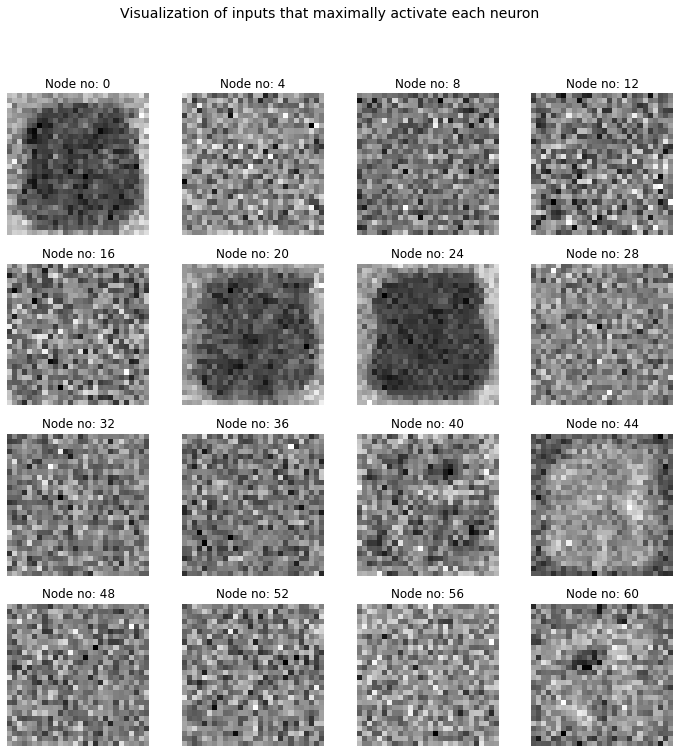

In [75]:
fig,axes = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axes.flatten()):
    j = 4*i
    ax.set_title("Node no: "+str(j),fontsize=12)
    ax.imshow(wts1[j],cmap='gray')
    ax.axis('off')
fig.suptitle('Visualization of inputs that maximally activate each neuron',fontsize=14)
plt.savefig('./img/wts_noise1.png')
plt.show()
plt.close()